In [1]:
import pandas as pd
import numpy as np
import requests
binance  = "https://www.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1d"
r = requests.get(binance)
data = r.json()

from math import log10
df = pd.DataFrame(columns=["price"])
for row in data:
    df = df.append(pd.DataFrame([float(row[1])],columns=df.columns))
df.index = [i for i in range(df.shape[0])]
df

,price
0,4261.48
1,4285.08
2,4108.37
3,4120.98
4,4069.13
5,4016.00
6,4040.00
7,4147.00
8,4316.01
9,4280.71


In [2]:
df.shape

(259, 1)

In [3]:
data_size = df.shape[0]
x_size = 7
y_size = 1

In [4]:
column_names_x = list()
for i in range(x_size):
    column_names_x.append("x"+str(i+1))
    
column_names_y = list()
for i in range(y_size):
    column_names_y.append("y"+str(i+1))
cols = ["index"]
cols += column_names_x
cols += column_names_y

In [5]:
"""Moving Window Transformation of Logged Data with window sizes: x->30 y->1"""
moving_window = pd.DataFrame(columns=cols)
for i in range(data_size-(x_size+y_size)+1):
        row = np.array([i])
        window = np.log10(df['price'].values[i:i+(x_size+y_size)])
        """Local Normalization Step"""
        window = [w-window[0] for w in window ]
        row = np.append(row,window)
        moving_window = moving_window.append(pd.DataFrame([row],columns=cols))

In [6]:
from sklearn.metrics import mean_squared_error, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Lambda
from math import sqrt
from math import log10
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from keras.callbacks import History
def build_model(x,y,input_size,output_size,epochs=1000):
    batch_size = 1
    model = Sequential()
    model.add(LSTM(128,return_sequences=True,batch_input_shape=(batch_size,input_size,1),stateful=True))
    model.add(LSTM(32,stateful=True))
    model.add(Dense(128))
    model.add(Activation('tanh'))
    model.add(Dense(64))
    model.add(Activation('tanh'))
    model.add(Dense(16))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    history = History()
    #for i in range(1000):
        #if i % 200 == 0: print(i)
    model.fit(x,y,batch_size=batch_size,epochs=epochs,shuffle=False,verbose=1,callbacks=[history])
    #model.reset_states()
    return model,history

def sMAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred)/2) )) * 100

def prepare_xy(train,y_size):

    x,y = train.iloc[:,:-y_size],train.iloc[:,-y_size:]
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(x.shape[0],x.shape[1],1)
    y = y.reshape(y.shape[0],y.shape[1])
    return x,y

def pred(data,model,y_size):
    
    preds = np.array([])
    for i in range(data.shape[0]):
        pred = np.array([])
        #pred = np.append(pred,data.iloc[i,0])
        #pred = np.append(pred,data.iloc[i,1])
        
        x_t = data.iloc[i,:-y_size]
        y_t = data.iloc[i,-y_size:]
        
        x_t,y_t = np.array(x_t),np.array(y_t)
        x_t = x_t.reshape(1,x_t.shape[0],1)
        
        yhat = model.predict(x_t,batch_size=1)
        yhat = yhat.reshape(yhat.shape[1],)
        for y in yhat:
            pred = np.append(pred,y)
        preds = np.append(preds,pred,axis=0)
    return preds

Using TensorFlow backend.


In [7]:
moving_window.shape

(252, 9)

In [8]:
data = moving_window.drop(['index'],axis=1)
data.head()

,x1,x2,x3,x4,x5,x6,x7,y1
0,0.0,0.002398,-0.015891,-0.014560,-0.020059,-0.025767,-0.023179,-0.011826
0,0.0,-0.018289,-0.016958,-0.022457,-0.028165,-0.025578,-0.014225,0.003124
0,0.0,0.001331,-0.004168,-0.009876,-0.007288,0.004064,0.021413,0.017846
0,0.0,-0.005499,-0.011207,-0.008619,0.002734,0.020082,0.016515,0.021739
0,0.0,-0.005708,-0.003120,0.008232,0.025581,0.022014,0.027238,0.024977


In [9]:
test_size = 7
train_size = moving_window.shape[0]-test_size
train = data[:train_size]
test = data[-test_size:]
x,y = prepare_xy(train,y_size=y_size)

In [10]:
st = time.time()
model,history = build_model(x,y,input_size=x_size,output_size=y_size,epochs=400)
ft = time.time()

Epoch 1/400
245/245 [==============================] - 3s - loss: 0.0052     
Epoch 2/400
245/245 [==============================] - 2s - loss: 0.0051     
Epoch 3/400
245/245 [==============================] - 2s - loss: 0.0045     
Epoch 4/400
245/245 [==============================] - 2s - loss: 0.0023     
Epoch 5/400
245/245 [==============================] - 2s - loss: 0.0014     
Epoch 6/400
245/245 [==============================] - 2s - loss: 0.0011     
Epoch 7/400
245/245 [==============================] - 2s - loss: 9.5543e-04     
Epoch 8/400
245/245 [==============================] - 2s - loss: 8.8875e-04     
Epoch 9/400
245/245 [==============================] - 2s - loss: 8.5935e-04     
Epoch 10/400
245/245 [==============================] - 2s - loss: 8.4934e-04     
Epoch 11/400
245/245 [==============================] - 2s - loss: 8.3707e-04     
Epoch 12/400
245/245 [==============================] - 2s - loss: 8.3676e-04     
Epoch 13/400
245/245 [===============

245/245 [==============================] - 2s - loss: 0.0054     
Epoch 102/400
245/245 [==============================] - 2s - loss: 0.0054     
Epoch 103/400
245/245 [==============================] - 2s - loss: 0.0054     
Epoch 104/400
245/245 [==============================] - 2s - loss: 0.0054     
Epoch 105/400
245/245 [==============================] - 2s - loss: 0.0054     - ETA: 0s - loss: 0
Epoch 106/400
245/245 [==============================] - 2s - loss: 0.0054     
Epoch 107/400
245/245 [==============================] - 2s - loss: 0.0054     
Epoch 108/400
245/245 [==============================] - 2s - loss: 0.0054     
Epoch 109/400
245/245 [==============================] - 2s - loss: 0.0054     
Epoch 110/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 111/400
245/245 [==============================] - 2s - loss: 0.0069     
Epoch 112/400
245/245 [==============================] - 2s - loss: 0.0064     
Epoch 113/400
245/245 [============

245/245 [==============================] - 2s - loss: 0.0061     
Epoch 204/400
245/245 [==============================] - 2s - loss: 0.0061     
Epoch 205/400
245/245 [==============================] - 2s - loss: 0.0061     
Epoch 206/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 207/400
245/245 [==============================] - 2s - loss: 0.0061     
Epoch 208/400
245/245 [==============================] - 2s - loss: 0.0060     
Epoch 209/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 210/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 211/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 212/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 213/400
245/245 [==============================] - 2s - loss: 0.0061     
Epoch 214/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 215/400
245/245 [==============================]

245/245 [==============================] - 2s - loss: 0.0062     
Epoch 306/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 307/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 308/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 309/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 310/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 311/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 312/400
245/245 [==============================] - 2s - loss: 0.0061     
Epoch 313/400
245/245 [==============================] - 2s - loss: 0.0060     
Epoch 314/400
245/245 [==============================] - 2s - loss: 0.0061     
Epoch 315/400
245/245 [==============================] - 2s - loss: 0.0062     
Epoch 316/400
245/245 [==============================] - 2s - loss: 0.0061     
Epoch 317/400
245/245 [==============================]

In [11]:
ft-st

956.7580151557922

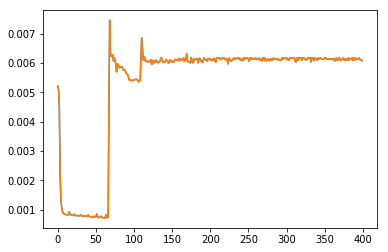

In [13]:
plt.plot(history.history['loss'])
plt.show()

In [14]:
preds = pred(test,model,y_size=1)
"""Renormalization and Get Rid of Log"""
for i,p in enumerate(preds):
    preds[i] = 10**(p+np.log10(df['price'].values[-30+i]))

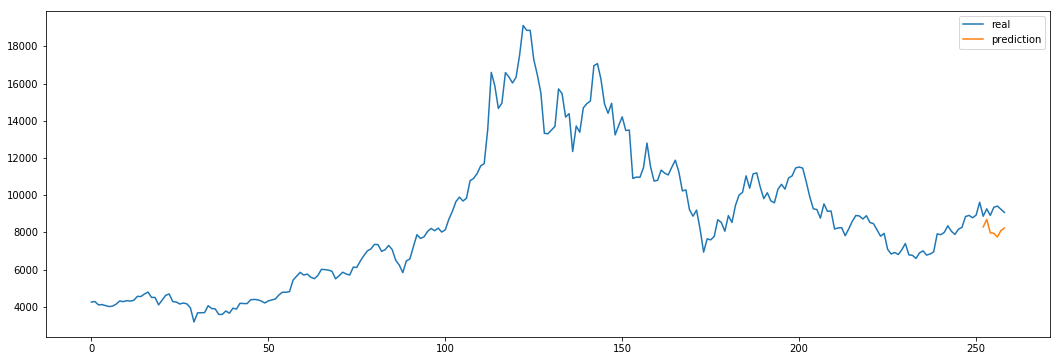

In [15]:
plt.figure(figsize=(18,6))
plt.plot(pd.Series(df['price'].values,index=range(df.shape[0])),label="real")
plt.plot(pd.Series(preds,index=range(df.shape[0]-test_size,df.shape[0])),label="prediction")
plt.legend()
plt.show()

In [16]:
sMAPE(df['price'].values[-test_size:],preds)

11.78795239305545

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(df['price'][-test_size:], preds))
rms

1086.4584005053184